The dataset was uploaded to Kaggle in 06/2020 by Yamaç Eren Ay, who used the Spotify Web API for develepors to build a data that contains more than 160,000 songs. These are NOT all the spotify tracks, but quite alot of it...

The task in this dataset is to predict the popularity of the track according to the track's features.

Each row in the data represent a unique track, identified by a unique ID feature generated by Spotify.

In [3]:
import pandas as pd     
import numpy as np
import scipy as sp                     
import matplotlib.pyplot as plt
import regex as re

# For validation
from sklearn.model_selection import train_test_split   #test and train
from sklearn.impute import SimpleImputer #transformer for completing missing values
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_squared_log_error as msle # relative error
from sklearn.metrics import mean_squared_error as mse  # absolute error
 
#For Visualization
import seaborn as sns


# For curve fitting
from scipy.optimize import curve_fit


In [4]:
df_raw = pd.read_csv('spotify_data.csv')
df_raw.head(5)

valence  year  acousticness  ... release_date  speechiness    tempo
0   0.0594  1921         0.982  ...         1921       0.0366   80.954
1   0.9630  1921         0.732  ...         1921       0.4150   60.936
2   0.0394  1921         0.961  ...         1921       0.0339  110.339
3   0.1650  1921         0.967  ...         1921       0.0354  100.109
4   0.2530  1921         0.957  ...         1921       0.0380  101.665

[5 rows x 19 columns]

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **EDA**

In [6]:
sns.pairplot(df_raw)

Output hidden; open in https://colab.research.google.com to view.

Coulmns drop

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [ ]:
df_raw.id.value_counts()

2l0xjJ6Fj72Bw4ReAJBrAo    1
2yBVAoyzE9SjASR4sIHbRS    1
525UWzrsdj4H3uorulg25x    1
7jkaDdbkFbL108GVwC7SWB    1
4TG9xTrkJOC8dfeUxfw6cv    1
                         ..
3uq6qe8ouF012GLOcLyWcH    1
6fBwVe6udYdnRqwqo06if8    1
2dacKJVYe7xsAcUrkOCSHL    1
4yumMRCiPOmwB9sfwJkTcB    1
3GYUtXAZC3QiNjbEmE7Jo3    1
Name: id, Length: 170653, dtype: int64

Duplication drop

In [ ]:
df_raw.groupby(['artists','name']).year.count().sort_values(ascending= False)
#neta

artists                                                           name                                
['Frédéric Chopin', 'Vladimir Horowitz']                          Ballade No. 1 in G Minor, Op. 23        11
['KAROL G']                                                       A Ella                                  11
['Modest Mussorgsky', 'William Kapell']                           Pictures at an Exhibition: Promenade     8
['Daddy Yankee']                                                  Limbo                                    8
['KAROL G', 'Ozuna']                                              Hello                                    7
                                                                                                          ..
['Oh Wonder']                                                     Technicolour Beat                        1
                                                                  Lose It                                  1
                         

Nan drop

In [ ]:
df_raw.select_dtypes(float).columns

Index(['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo'],
      dtype='object')

In [ ]:
def zero_dropper(df):
  float_cols = df.select_dtypes(float).columns
  for c in float_cols:
    df = df[df[c]>df[c].min()]
    df = df[~df[c].isna()]
  return df
df = FunctionTransformer(zero_dropper).fit_transform(df_raw)
# #Ido


In [ ]:
df.head(1)

valence  year  acousticness  ... release_date  speechiness   tempo
0   0.0594  1921         0.982  ...         1921       0.0366  80.954

[1 rows x 19 columns]

outliers drop

In [ ]:
## neta

Feature enegeniring

In [ ]:
# # Ido
# !pip install holidays
# import holidays
# holiday_list = []
# for date in holidays.UnitedStates(years= df_raw.year.unique()).items():
#   holiday_list.append(str(date[0]))

# holiday_df = pd.Series(holiday_list)
# df['holiday_release_date'] = df.release_date.apply(lambda x: any(x==holiday_df))
# df.groupby(['holiday_release_date']).popularity.mean().plot.bar()

Using legacy 'setup.py install' for pymeeus, since package 'wheel' is not installed.
    Running setup.py install for pymeeus: started
    Running setup.py install for pymeeus: finished with status 'done'


<AxesSubplot:xlabel='holiday'>

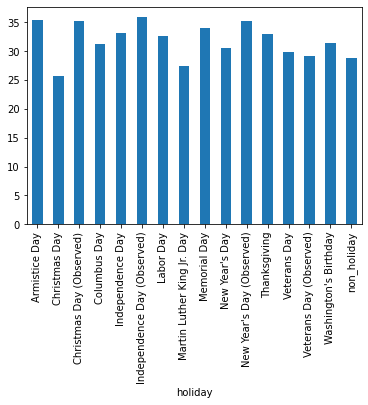

In [ ]:
import holidays
holiday_days_list = []
holiday_list = []

for date in holidays.UnitedStates(years= df_raw.year.unique()).items():
  holiday_days_list.append(str(date[0]))
  holiday_list.append(str(date[1]))

holiday_df = pd.DataFrame( data={'release_date': holiday_days_list ,'holiday_list':holiday_list})

df['holiday'] = pd.merge(df.release_date, 
                     holiday_df, 
                     on ='release_date', 
                     how ='left').holiday_list
df.holiday = df.holiday.replace(np.nan,'non_holiday')
df.groupby('holiday').popularity.mean().plot.bar()

In [ ]:
df.head(1)

valence  year  acousticness  ... speechiness   tempo      holiday
0   0.0594  1921         0.982  ...      0.0366  80.954  non_holiday

[1 rows x 20 columns]

In [ ]:
## artists transform
def artists_transform(df):
  pattern = '([\w*\s?\w]+)\s?&?,?\s?'
  df.artists = df.artists.apply(lambda x: re.findall(pattern,x))
  df = df.apply(lambda x: x.explode()) 
  df = df[df.artists!= ' ']
  return df

df = FunctionTransformer(artists_transform).transform(df)

In [ ]:
df.head(1)

valence  year  acousticness  ... speechiness   tempo      holiday
0   0.0594  1921         0.982  ...      0.0366  80.954  non_holiday

[1 rows x 20 columns]

### **scaling and pre-proccesing**



<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


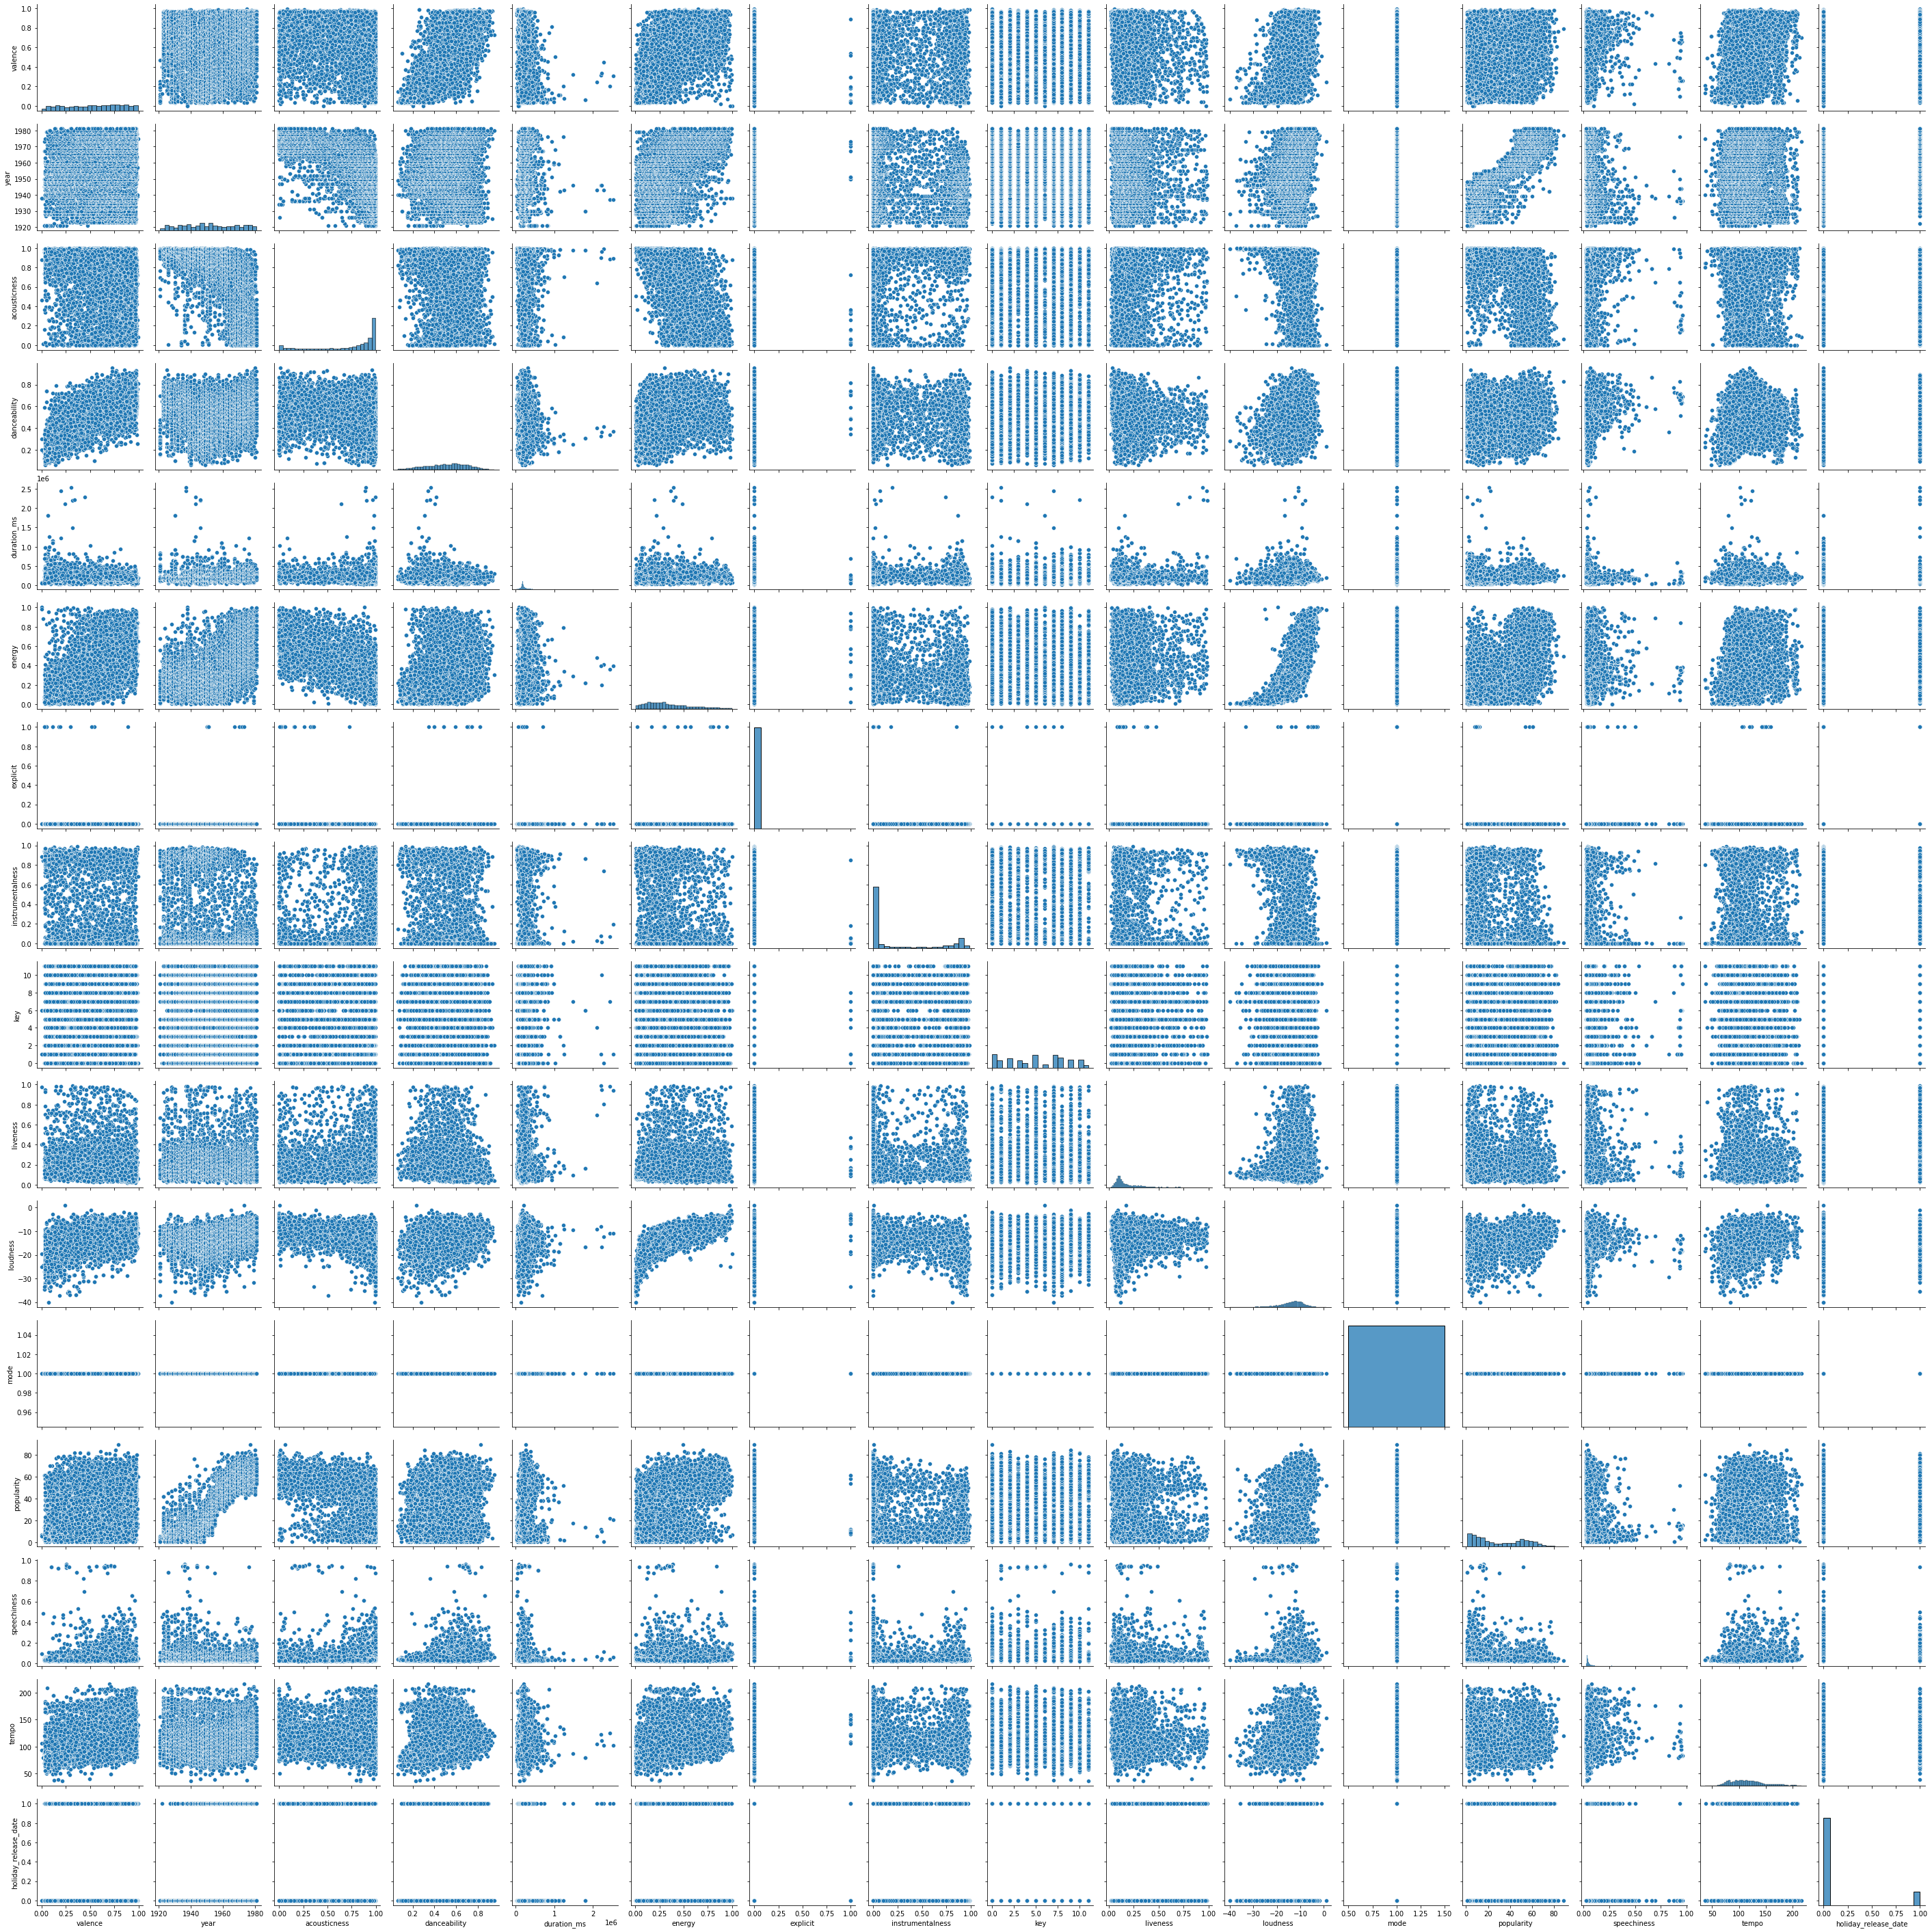

In [ ]:
sns.pairplot(df)

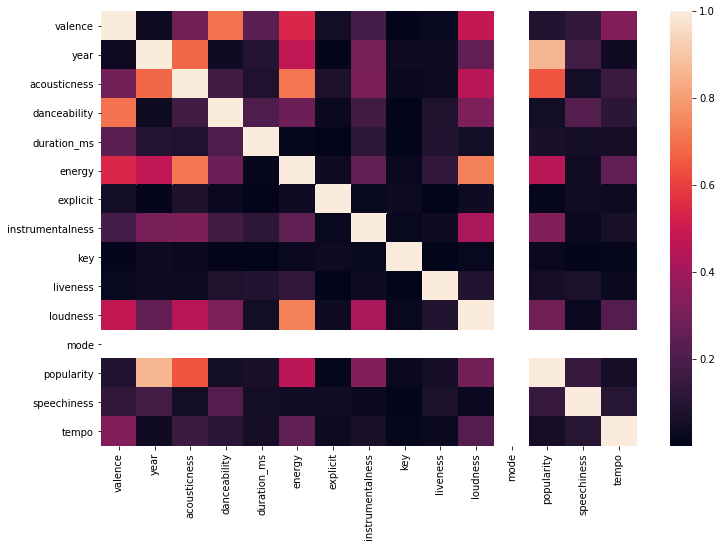

In [ ]:
plt.figure( figsize= (12,8))
num_cols = df.select_dtypes(include = [float,int])
sns.heatmap(abs(num_cols.corr()))

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


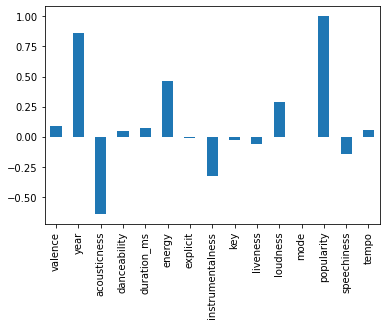

In [ ]:
corr_parameters= pd.DataFrame(columns= ['r','p_value'])
for c in num_cols:
  r,p= sp.stats.pearsonr(num_cols[f'{c}'],num_cols.popularity)
  corr_parameters.loc[c,'r'] = r
  corr_parameters.loc[c,'p_value'] = p

corr_parameters.r.plot.bar()

In [ ]:
df.head(1)

valence  year  ...      holiday  holiday_release_date
0   0.0594  1921  ...  non_holiday                 False

[1 rows x 11 columns]

In [ ]:
#drop erelvant coulmns
df1 = df.drop(columns= ['danceability','duration_ms','acousticness','key','explicit','tempo','release_date','liveness','id','mode','name'])


In [ ]:
df2 = pd.get_dummies(df1,drop_first= True)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns= 'popularity'), df2.popularity, test_size= 0.3, random_state= 12345)

In [ ]:
lin_model = LinearRegression().fit(X_train, y_train)
y_pred_train = lin_model.predict(X_train)
print('train RMSE: ', np.sqrt(mse(y_pred_train, y_train)))
# print('train RMSLE: ', np.sqrt(msle(y_pred_train, y_train)))

y_pred_test = lin_model.predict(X_test)
print('test RMSE: ', np.sqrt(mse(y_pred_test, y_test)))
# print('test RMSLE: ', np.sqrt(msle(y_pred_test, y_test)))

MemoryError: Unable to allocate 23.0 GiB for an array with shape (126076, 24516) and data type float64

In [ ]:
d_tree_model = DecisionTreeClassifier(min_samples_leaf=5 , max_depth= 150).fit(X_train, y_train)
y_pred_train = d_tree_model.predict(X_train)
print('train RMSE: ', np.sqrt(mse(y_pred_train, y_train)))
# print('train RMSLE: ', np.sqrt(msle(y_pred_train, y_train)))

y_pred_test = d_tree_model.predict(X_test)
print('test RMSE: ', np.sqrt(mse(y_pred_test, y_test)))
# print('test RMSLE: ', np.sqrt(msle(y_pred_test, y_test)))

train RMSE:  9.705270776566389
test RMSE:  11.227413698254287


In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
y_pred_train = d_tree_model.predict(X_train)
print('train RMSE: ', np.sqrt(mse(y_pred_train, y_train)))
# print('train RMSLE: ', np.sqrt(msle(y_pred_train, y_train)))

y_pred_test = d_tree_model.predict(X_test)
print('test RMSE: ', np.sqrt(mse(y_pred_test, y_test)))
# print('test RMSLE: ', np.sqrt(msle(y_pred_test, y_test)))

train RMSE:  9.705270776566389
test RMSE:  11.227413698254287


In [ ]:
df3 = df3.drop(columns= 'release_date')